## Computer Vision

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Loading the file containing images with details of bounding boxes

In [2]:
import numpy as np
data = np.load('/content/drive/My Drive/images.npy', allow_pickle=True)

### Checking one sample from the loaded file 

In [3]:
data[10][1]

[{'imageHeight': 337,
  'imageWidth': 600,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.48, 'y': 0.10385756676557864},
   {'x': 0.7716666666666666, 'y': 0.6795252225519288}]}]

### Setting image dimensions 

In [4]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Creating features and labels

In [5]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Splitting the data into training and testing 
- 400 images in training
- 9 images in testing data

Training data

In [6]:
X_train = X[:400]
y_train = masks[:400]

Testing data

In [7]:
X_test = X[400:]
y_test = masks[400:]

### Printing a sample training image, image array and its mask 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image array: [[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.9

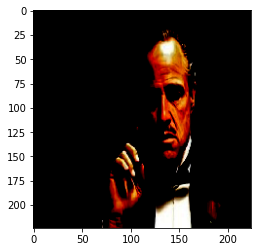

In [8]:
import matplotlib.pyplot as plt

n = 10    
print("Image array:", X_train[n])
plt.imshow(X_train[n])

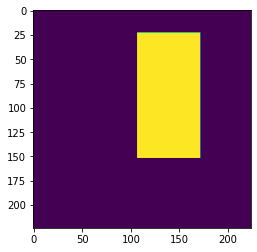

In [9]:
plt.imshow(masks[n])

## Create the model 
- Addding MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Adding UNET architecture layers

In [10]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
  
    block0 = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block0])
    print(x.shape)
    x = UpSampling2D()(x)
    print(x.shape)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    print(x.shape)

    return Model(inputs=model.input, outputs=x)

### Calling the create_model function 

In [11]:
model = create_model()

17227776/17225924 [==============================] - 1s 0us/step
(None, 14, 14, 1536)
(None, 28, 28, 1792)
(None, 56, 56, 1920)
(None, 112, 112, 1984)
(None, 224, 224, 1984)
(None, 224, 224)


### Printing model summary 

In [12]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_______________________________________________________________________________________

### Defining dice coefficient function 
- Creating a function to calculate dice coefficient


In [13]:
from tensorflow import reduce_sum
from tensorflow.keras.backend import epsilon

def dice_coefficient(y_true, y_pred):
    numerator = 2 * reduce_sum(y_true * y_pred)
    denominator = reduce_sum(y_true + y_pred)
    return numerator / (denominator + epsilon())

### Defining loss function 

In [14]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compiling the model using below parameters
  - loss: using the loss function defined above
  - optimizer: using Adam optimizer
  - metrics: using dice_coefficient function defined above

In [15]:
model.compile(loss=loss, optimizer='adam', metrics=[dice_coefficient])

### Defining callbacks
- Using ModelCheckpoint
- Using EarlyStopping
- Using ReduceLROnPlateau

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fitting the model using below parameters
  - epochs: 10
  - batch_size: 1
  - callbacks: using the callbacks defined above

In [17]:
model.fit(X_train, y_train, epochs=10, batch_size=1, callbacks=[checkpoint, reduce_lr, stop])

Epoch 1/10
399/400 [============================>.] - ETA: 0s - loss: 1.2285 - dice_coefficient: 0.5104
Epoch 00001: loss improved from inf to 1.22734, saving model to model-1.23.h5
400/400 [==============================] - 14s 34ms/step - loss: 1.2273 - dice_coefficient: 0.5105
Epoch 2/10
399/400 [============================>.] - ETA: 0s - loss: 0.8376 - dice_coefficient: 0.6065
Epoch 00002: loss improved from 1.22734 to 0.83709, saving model to model-0.84.h5
400/400 [==============================] - 14s 34ms/step - loss: 0.8371 - dice_coefficient: 0.6068
Epoch 3/10
399/400 [============================>.] - ETA: 0s - loss: 0.7203 - dice_coefficient: 0.6485
Epoch 00003: loss improved from 0.83709 to 0.72050, saving model to model-0.72.h5
400/400 [==============================] - 14s 34ms/step - loss: 0.7205 - dice_coefficient: 0.6484
Epoch 4/10
399/400 [============================>.] - ETA: 0s - loss: 0.6843 - dice_coefficient: 0.6639
Epoch 00004: loss improved from 0.72050 to 0.

### Getting the predicted mask for a test image 

Showing the test image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


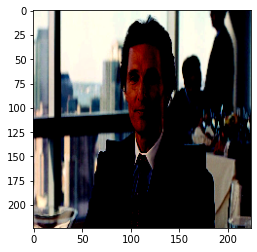

In [18]:
m = 3
plt.imshow(X_test[m])

Show original mask for test image

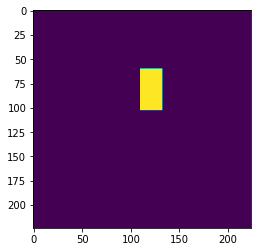

In [19]:
plt.imshow(masks[m])

Predicting the mask on the test image

In [20]:
pred_mask = cv2.resize(1.0 * (model.predict(x=np.array([X_test[m]]))[0] > 0.5), (IMAGE_WIDTH, IMAGE_HEIGHT)) 

### Imposing the mask on the test image
- In imshow using the alpha parameter and setting it to 0.9 (i.e. > 0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


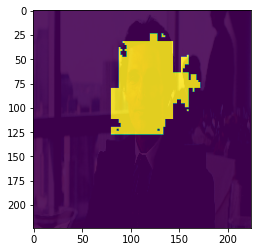

In [21]:
plt.imshow(X_test[m])
plt.imshow(pred_mask, alpha=0.9)